# *This notebook contains:*
### A. EDA for movielens dataset
### B. Finding best and worst movies with deep learning aproach
### C. Implementation of ALS Matrix Factorization from scratch 

In [117]:
import pandas as pd 
import numpy as np
import os, time, random

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import seaborn as sns
sns.set(rc={'figure.figsize':(15,10)})
from wordcloud import WordCloud

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Input, add, dot, Flatten, Embedding,Dropout, concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers

In [118]:
ratings = pd.read_csv('/home/badal/Desktop/Movie Recommendation/Movielens data/movielens_small/ratings.csv')

In [144]:
movies = pd.read_csv('/home/badal/Desktop/Movie Recommendation/Movielens data/movielens_small/movies.csv')

In [120]:
df = ratings.merge(movies, how = 'inner')
df['timestamp'] = df['timestamp'].apply(lambda x: time.strftime('%Y', time.localtime(x)))
df.rename(columns={'timestamp':'Year'}, inplace=True)

# A. EDA for movielens dataset

### For this section, I generated some questions that I want to answer.

# *Question 1:*
### What is the distubiton of user ratings ?

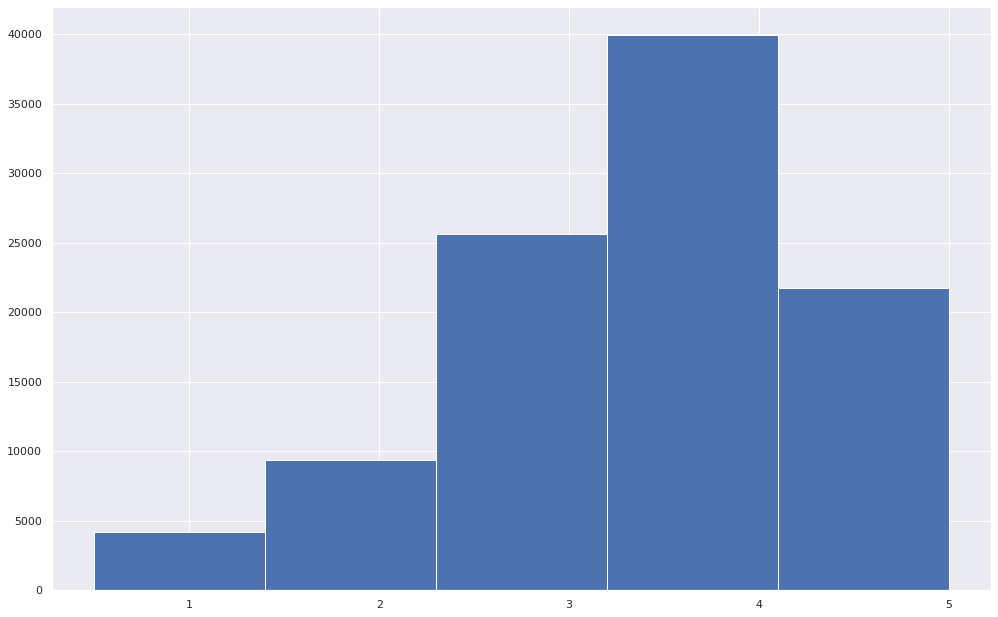

In [50]:
df.rating.hist(bins=5)

# *Question 2-1:*
### Is number of reviews correlated with higher ratings ?
    (Does most rated movies also get higher ratings ?)

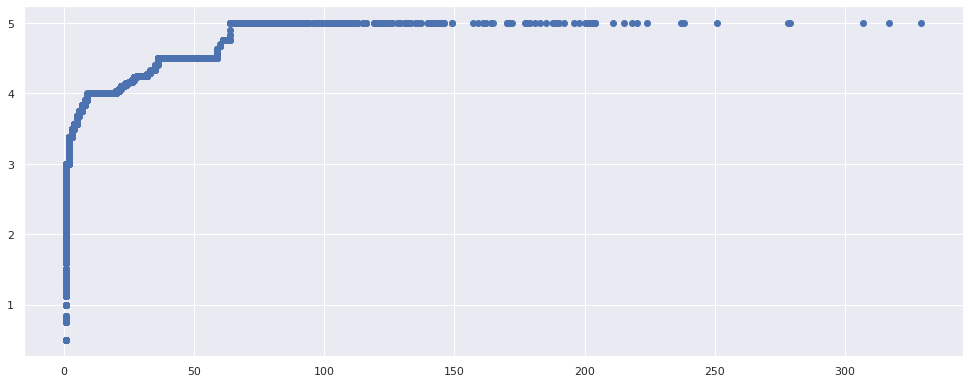

In [51]:

rating_counts = df.groupby('movieId')[['rating']].count().sort_values(by='rating', ascending=False)
avg_ratings = df.groupby('movieId')[['rating']].mean().sort_values(by='rating', ascending=False)
plt.figure(figsize=(15,6))
plt.scatter(rating_counts, avg_ratings)
plt.show()

Above plot shows, movies that got reviews more than 50 ended up getting ratings higher than 4

# *Question 2-2:*
### Does movies that get ratings above the average also ends up with higher number of reviews ?

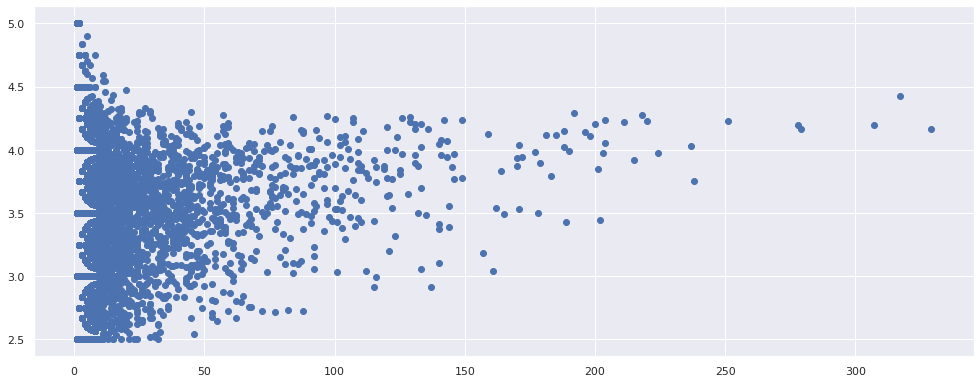

In [52]:
locs = avg_ratings[avg_ratings['rating'] >=2.5].index
plt.figure(figsize=(15,6))
plt.scatter(rating_counts.loc[locs], avg_ratings[avg_ratings['rating'] >=2.5]['rating'])
plt.show()

# Question 3:
### What are the most rated genres ? 

In [53]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [54]:
df.genres = df.genres.str.split('|')
df = explode(df, ['genres'])

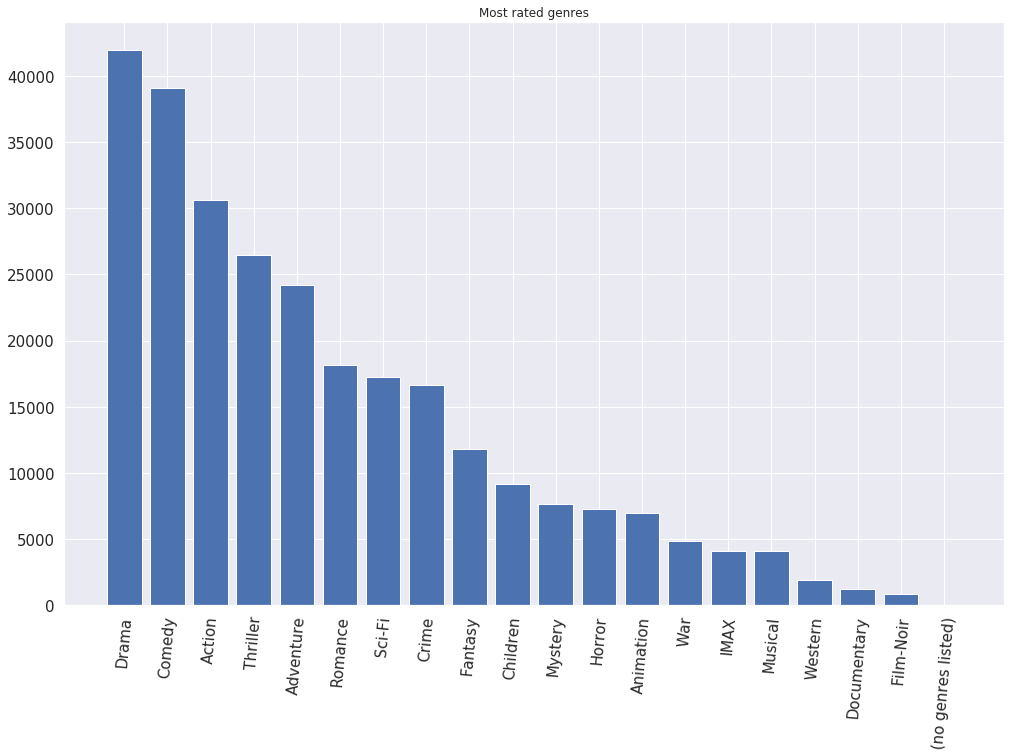

In [55]:
most_rated_genres =  df.groupby('genres')[['rating']].count().sort_values('rating', ascending=False)
figure = plt.figure(figsize=(15,10))
plt.bar(most_rated_genres.index, most_rated_genres.rating)
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Most rated genres')
plt.show()

In [56]:
words = dict()
for i in df.genres.value_counts().iteritems():
    words[i[0]] = i[1]

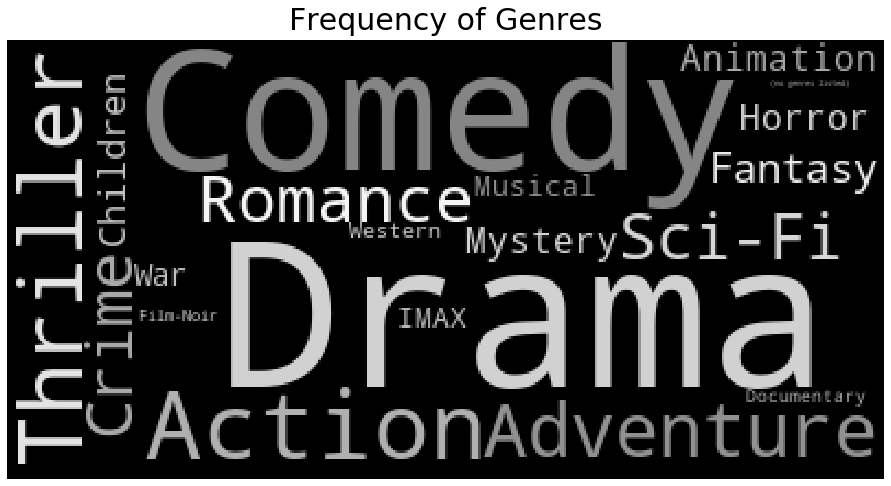

In [69]:
def grey_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'hsl(0, 0%%, %d%%)' % random.randint(50, 100)

def generateWordCloud(words):
    limit = 1000
    infosize = 12
    title = 'Frequency of Genres'
    fontcolor='black'
    bgcolor = '#000000'

    wordcloud = WordCloud(
        max_words=500,
        background_color=bgcolor,
    ).generate_from_frequencies(words)
    fig = plt.figure()
    fig.set_figwidth(14)
    fig.set_figheight(18)
    plt.imshow(wordcloud.recolor(color_func=grey_color, random_state=3))
    plt.title(title, color=fontcolor, size=30, y=1.01)
    plt.axis('off')
    plt.show()

generateWordCloud(words)

# Question 4:
### What are the most rated movies ?

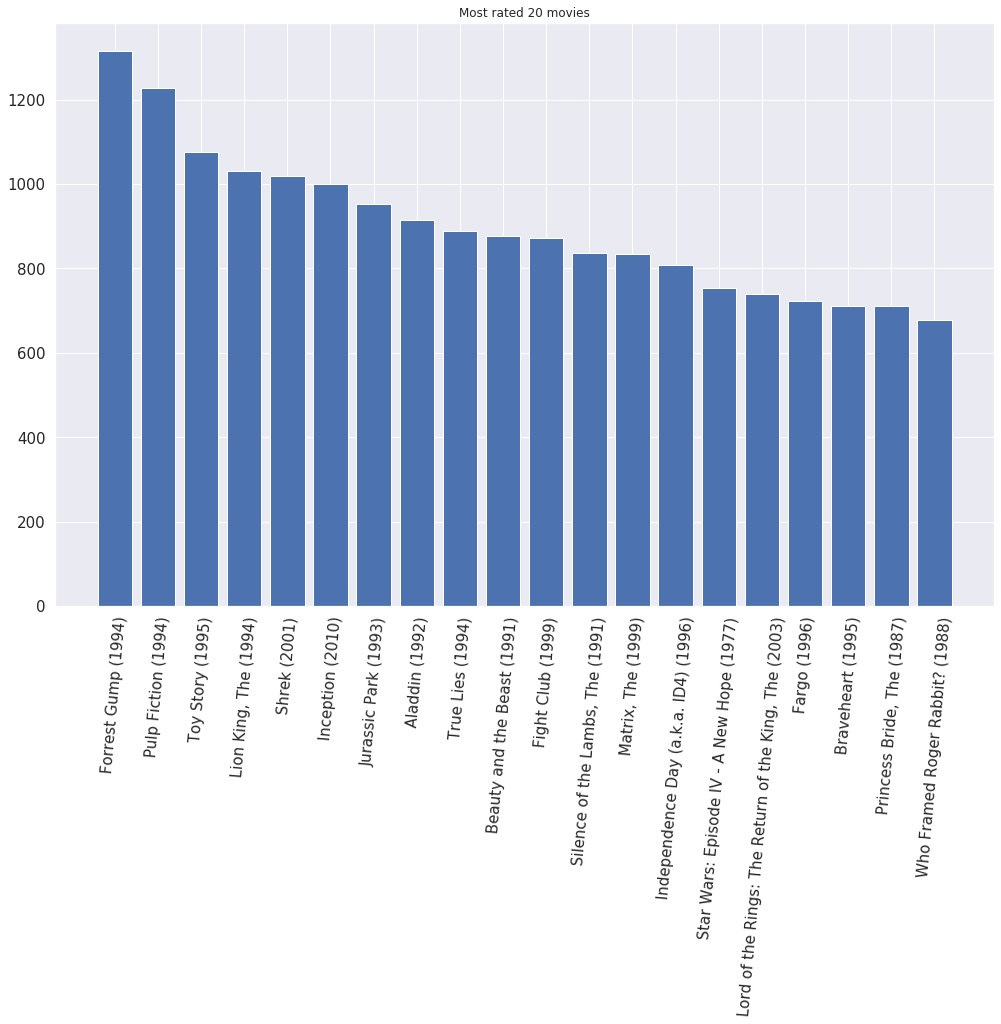

In [58]:
most_rated_movies = df.groupby('title')[['rating']].count().sort_values('rating', ascending=False)[:20]
figure = plt.figure(figsize=(15,10))
plt.bar(most_rated_movies.index, most_rated_movies.rating)
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.title('Most rated 20 movies')
plt.show()

# Question 5:
### What is the rating trend in movie genres ? 

In [59]:
rating_by_gen_year = df.groupby(['genres', 'Year'])[['rating']].mean()

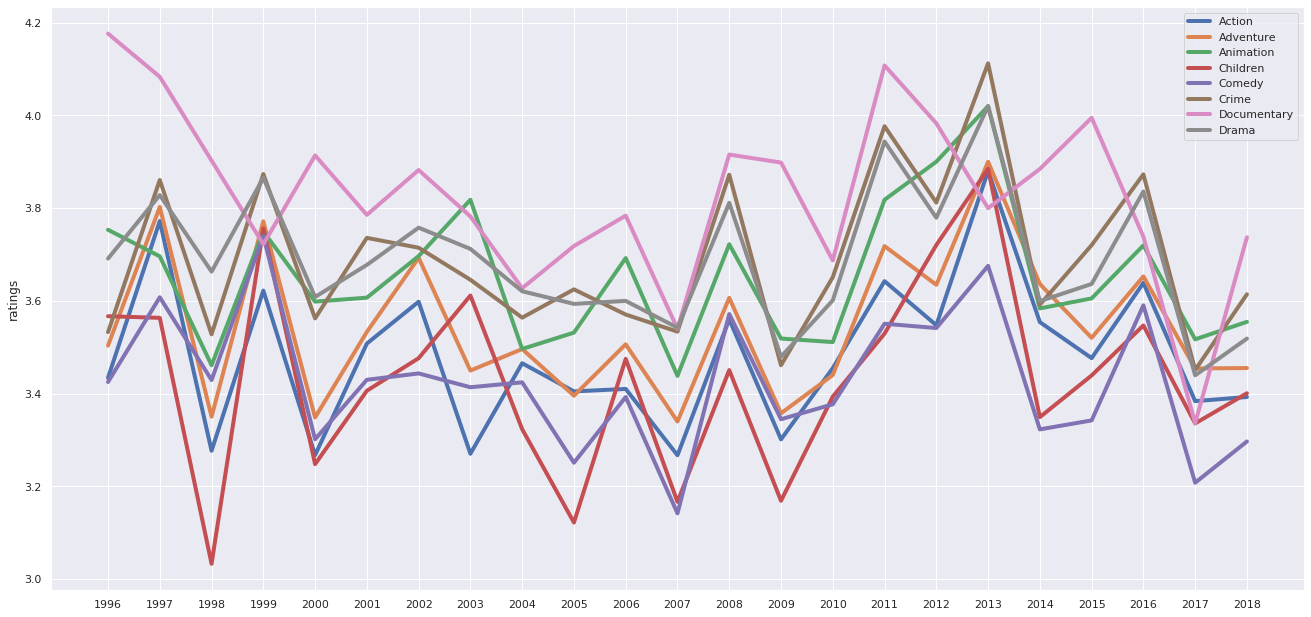

In [72]:
plt.figure(figsize=(20,10))
for i in rating_by_gen_year.index.levels[0].to_list()[:9]:
    if i == '(no genres listed)':
        continue
    plt.plot(rating_by_gen_year.loc[i].index, rating_by_gen_year.loc[i], label=i, linewidth=4)
plt.ylabel('ratings')
plt.legend(loc='best')
plt.show()

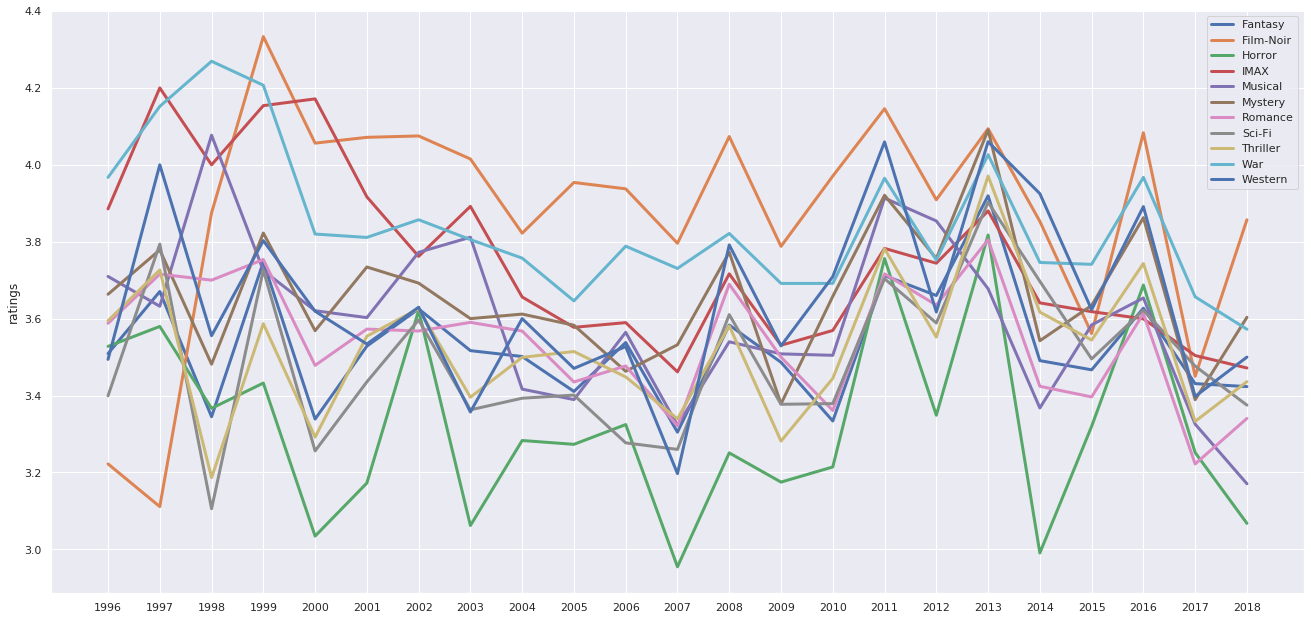

In [73]:
plt.figure(figsize=(20,10))
for i in rating_by_gen_year.index.levels[0].to_list()[9:]:
    if i == '(no genres listed)':
        continue
    plt.plot(rating_by_gen_year.loc[i].index, rating_by_gen_year.loc[i], label=i, linewidth = 3)
plt.ylabel('ratings')
plt.legend(loc='best')
plt.show()

# Question 6:
### What is the distribution of ratings by genres ? 

In [62]:
rts_by_mId_gen = df.groupby(['movieId', 'genres'], as_index=False)[['rating']].mean()

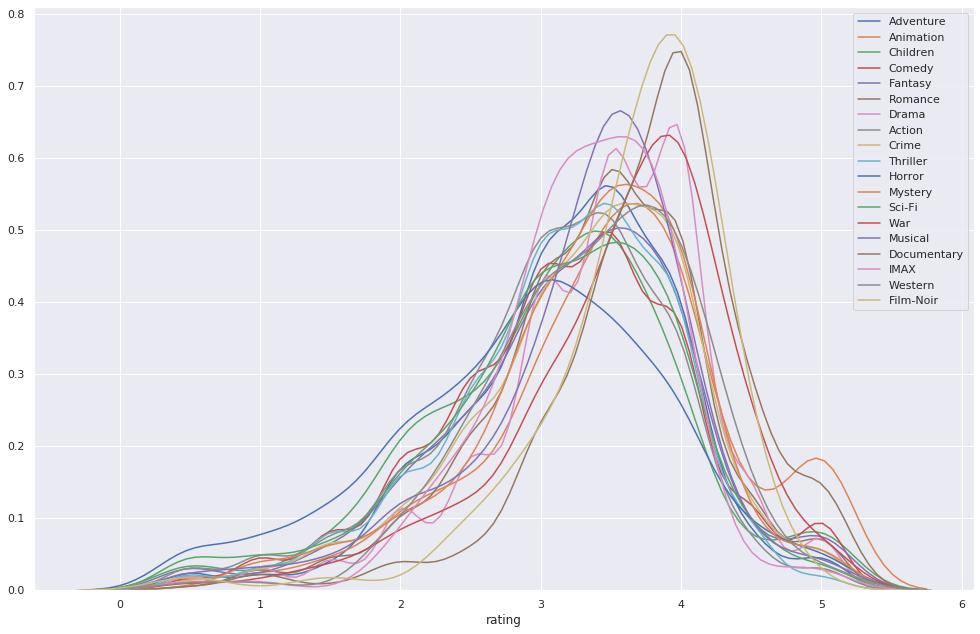

In [63]:
for v in rts_by_mId_gen.genres.unique():
    if v == '(no genres listed)':
        continue
    fig = sns.distplot(rts_by_mId_gen[rts_by_mId_gen['genres'] == v]['rating'],hist=False, label=v)
plt.show()

# Question 7:
### Movies with witch release date got more reviews ?

In [64]:
df['release_date'] = df.title.str[-5:-1]

In [65]:
rts_by_users = df.groupby('userId')[['rating']].mean().sort_values('rating', ascending=False)

In [66]:
df_to_plot = df.set_index('userId').loc[rts_by_users[rts_by_users['rating'] >= 3].index]

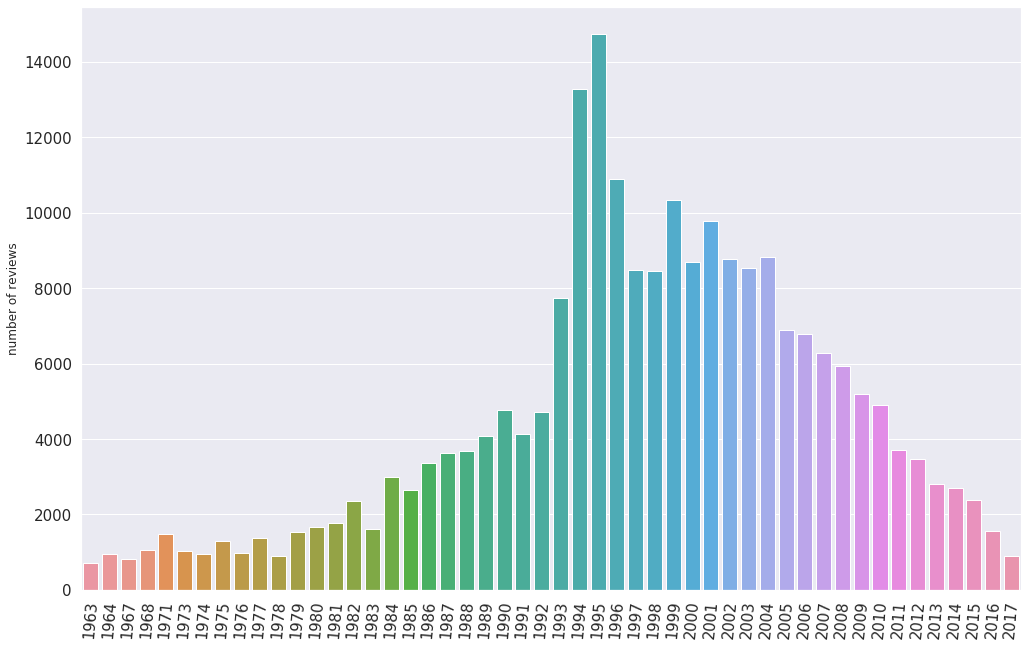

In [71]:
sns.barplot(x = df_to_plot.release_date.value_counts()[:50].index, 
            y = df_to_plot.release_date.value_counts()[:50])
plt.ylabel('number of reviews')
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

# Question 8:
### What is the number of reviews by genre ?

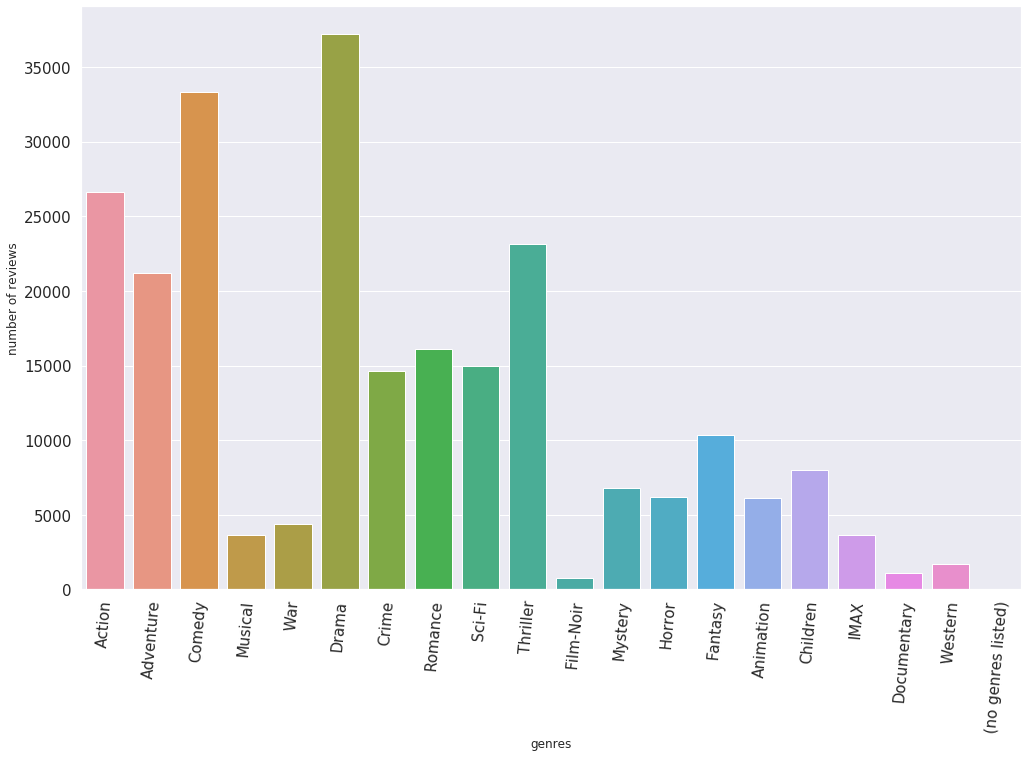

In [74]:
sns.countplot(x = df_to_plot.genres)
plt.xticks(rotation=85, fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel('number of reviews')
plt.show()

# B. Finding Best and Worst Movies

In [121]:
ratings.drop('timestamp', 1, inplace=True)

In [122]:
movies_not_in_ratings = [i for i in movies.movieId if i not in ratings.movieId.unique()]
indcs = movies.set_index('movieId').loc[movies_not_in_ratings].index
movies = movies.set_index('movieId').drop(index=indcs).reset_index()

In [37]:
'userId' in ratings.columns

True

In [44]:
def proc_data_for_model(data_name, movie_col, user_col):
    if data_name == 'ratings':
        unique_users = ratings[user_col].unique()
        user_to_indx = {v:i for i,v in enumerate(unique_users)}
        ratings[user_col] = ratings[user_col].apply(lambda val: user_to_indx[val])
        n_users = len(unique_users)
    
    else:
        movies[movie_col] = movies[movie_col].apply(lambda val: movie_to_indx[val])
        
    unique_movies = ratings[movie_col].unique()
    movie_to_indx = {o:i for i,o in enumerate(unique_movies)}
    ratings[movie_col] = ratings[movie_col].apply(lambda val: movie_to_indx[val])
    n_movies=len(unique_movies)

In [7]:
proc_data_for_keras(movies, 'movieId')

9724

In [8]:
n_users, n_movies = proc_data_for_keras(ratings, 'movieId', 'userId')

In [123]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [124]:
movies.movieId = movies.movieId.apply(lambda x: movie2idx[x])

In [125]:
train, val = train_test_split(ratings, test_size = 0.20)

In [126]:
n_factors = 50

In [127]:
def get_input(n_inputs, shape=(1,)):
    inputs = [Input(shape=shape) for arg in range(n_inputs)]
    return inputs
    
def get_emb(input_, input_dim, output_dim, inp_length, reg_func, name):
    emb = Embedding(input_dim, output_dim, input_length=inp_length, embeddings_regularizer=reg_func, name=name)(input_)
    return emb

def get_bias_emb(input_, input_dim):
    bias_emb = Embedding(input_dim=input_dim, output_dim=1, input_length=1)(input_)
    bias_emb = Flatten()(bias_emb)
    return bias_emb

In [128]:
u_inp, m_inp = get_input(2)
u_emb = get_emb(u_inp, n_users, n_factors, 1, l2(1e-4), 'user_embedding')
m_emb = get_emb(m_inp, n_movies, n_factors, 1, l2(1e-4), 'movie_embedding')
u_b, m_b = get_bias_emb(u_inp, n_users), get_bias_emb(m_inp, n_movies)

In [129]:
# opt = optimizers.Adam(0.001)
opt = optimizers.SGD(1e-1, decay=2e-4, momentum=0.9)

In [130]:
x = dot([u_emb, m_emb], axes=2)
x = Flatten()(x)
x = add([x, u_b])
x = add([x, m_b])
model = models.Model([u_inp, m_inp], x)
model.compile(opt, loss='mse')

In [131]:
model.fit([train.userId, train.movieId], train.rating, batch_size=512, epochs=15, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80668 samples, validate on 20168 samples
Epoch 1/15
80668/80668 [==============================] - 1s 17us/sample - loss: 6.4664 - val_loss: 3.2696
Epoch 2/15
80668/80668 [==============================] - 1s 14us/sample - loss: 2.4465 - val_loss: 2.0082
Epoch 3/15
80668/80668 [==============================] - 1s 14us/sample - loss: 1.7142 - val_loss: 1.5975
Epoch 4/15
80668/80668 [==============================] - 1s 14us/sample - loss: 1.4221 - val_loss: 1.3944
Epoch 5/15
80668/80668 [==============================] - 1s 14us/sample - loss: 1.2615 - val_loss: 1.2711
Epoch 6/15
80668/80668 [==============================] - 1s 14us/sample - loss: 1.1578 - val_loss: 1.1861
Epoch 7/15
80668/80668 [==============================] - 1s 14us/sample - loss: 1.0844 - val_loss: 1.1240
Epoch 8/15
80668/80668 [==============================] - 1s 14us/sample - loss: 1.0295 - val_loss: 1.0763
Epoch 9/15
80668/80668 [==============================] - 1s 14us/sample - loss: 0.9865 - val_

In [132]:
model.optimizer.lr = 1e-4
model.optimizer.decay = 2e-6

In [133]:
model.fit([train.userId, train.movieId], train.rating, batch_size=512, epochs=10, 
          validation_data=([val.userId, val.movieId], val.rating))

Train on 80668 samples, validate on 20168 samples
Epoch 1/10
80668/80668 [==============================] - 1s 14us/sample - loss: 0.8331 - val_loss: 0.9095
Epoch 2/10
80668/80668 [==============================] - 1s 14us/sample - loss: 0.8304 - val_loss: 0.9086
Epoch 3/10
80668/80668 [==============================] - 1s 14us/sample - loss: 0.8294 - val_loss: 0.9082
Epoch 4/10
80668/80668 [==============================] - 1s 14us/sample - loss: 0.8288 - val_loss: 0.9079
Epoch 5/10
80668/80668 [==============================] - 1s 14us/sample - loss: 0.8283 - val_loss: 0.9078
Epoch 6/10
80668/80668 [==============================] - 1s 14us/sample - loss: 0.8280 - val_loss: 0.9077
Epoch 7/10
80668/80668 [==============================] - 1s 14us/sample - loss: 0.8277 - val_loss: 0.9076
Epoch 8/10
80668/80668 [==============================] - 1s 16us/sample - loss: 0.8275 - val_loss: 0.9075
Epoch 9/10
80668/80668 [==============================] - 1s 14us/sample - loss: 0.8273 - val_

In [134]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()

#TopMovies are movies that got more reviews than others. 
topMovies=g.sort_values(ascending=False).index.values[:3000]

In [135]:
uniq = ratings.movieId.unique()
name2idx = {o:i for i,o in enumerate(uniq)}
topMovieIdx = np.array([name2idx[o] for o in topMovies])

In [136]:
get_movie_bias = models.Model(m_inp, m_b)
movie_bias = get_movie_bias.predict(topMovieIdx)

In [137]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

### Worst movies

In [138]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.5884824, 'Anaconda (1997)'),
 (-0.52901477, 'Speed 2: Cruise Control (1997)'),
 (-0.457693, 'Batman & Robin (1997)'),
 (-0.44615403, 'Battlefield Earth (2000)'),
 (-0.4014728, 'Jason X (2002)'),
 (-0.39804822, 'Godzilla (1998)'),
 (-0.39429906, 'Superman IV: The Quest for Peace (1987)'),
 (-0.38629612, 'Ultraviolet (2006)'),
 (-0.3859196, 'I Still Know What You Did Last Summer (1998)'),
 (-0.37488425, 'Dungeons & Dragons (2000)'),
 (-0.369798, 'Stuart Saves His Family (1995)'),
 (-0.3647338, 'Problem Child (1990)'),
 (-0.35014188, 'Flintstones in Viva Rock Vegas, The (2000)'),
 (-0.35009536, 'Rambo III (1988)'),
 (-0.35000908, 'Wild Wild West (1999)')]

### Best movies
#### I will use these movies in my online recommender app.

In [139]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:48]

[(1.9327284, 'Shawshank Redemption, The (1994)'),
 (1.7288336, "Schindler's List (1993)"),
 (1.6822045, 'Pulp Fiction (1994)'),
 (1.6502289, 'Usual Suspects, The (1995)'),
 (1.6427369, 'Fight Club (1999)'),
 (1.6345096, 'Braveheart (1995)'),
 (1.6195045, 'Silence of the Lambs, The (1991)'),
 (1.6112473, 'American History X (1998)'),
 (1.5904645, 'Dark Knight, The (2008)'),
 (1.5883354, 'Forrest Gump (1994)'),
 (1.5744127, 'Princess Bride, The (1987)'),
 (1.5582836,
  'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)'),
 (1.5526569, 'Matrix, The (1999)'),
 (1.5398921,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (1.5230426, 'Fugitive, The (1993)'),
 (1.521941, "Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)"),
 (1.5185318, 'Godfather, The (1972)'),
 (1.5161643, 'Star Wars: Episode IV - A New Hope (1977)'),
 (1.5140235, "One Flew Over the Cuckoo's Nest (1975)"),
 (1.510056, 'Lord of the Rings: The Return of the Kin

# C. Alternating Least Square (ALS) Matrix Factorization
### *Implementation of vanilla ALS with numpy*

In [3]:
Q = np.array([

     [5,3,0,1],

     [4,0,0,1],

     [1,1,0,5],

     [1,0,0,4],

     [0,1,5,4]

    ])

In [8]:
def get_error(Q, X, Y, W):
    return np.sum((W * (Q - np.dot(X, Y)))**2)

def vanilla_ALS(Q, n_iterations, n_factors, lambda_):
    m, n = Q.shape
    X = 5 * np.random.rand(m, n_factors) 
    Y = 5 * np.random.rand(n_factors, n)
    W = Q>0.5
    W[W == True] = 1
    W[W == False] = 0
    W = W.astype(np.float64, copy=False)
    
    trckr_x = 0
    trckr_y = 0
    weighted_errors = []
    for ii in range(n_iterations):
        for u, Wu in enumerate(W):
#             X[u] = np.linalg.solve(np.dot(Y, np.dot(np.diag(Wu), Y.T)) + lambda_ * np.eye(n_factors),
#                                    np.dot(Y, np.dot(np.diag(Wu), Q[u].T))).T
            X[u] = np.dot(np.linalg.inv(np.dot(Y, np.dot(np.diag(Wu), Y.T)) + lambda_ * np.eye(n_factors)),
                   np.dot(Y, np.dot(np.diag(Wu), Q[u].T))).T
    
        for i, Wi in enumerate(W.T):
#             Y[:,i] = np.linalg.solve(np.dot(X.T, np.dot(np.diag(Wi), X)) + lambda_ * np.eye(n_factors),
#                                    np.dot(X.t, np.dot(np.diag(Wi), Q[:,i])))
        
            Y[:,i] = np.dot(np.linalg.inv(np.dot(X.T, np.dot(np.diag(Wi), X)) + lambda_ * np.eye(n_factors)),
                                     np.dot(X.T, np.dot(np.diag(Wi), Q[:, i])))
        weighted_errors.append(get_error(Q, X, Y, W))
        #print('{}th iteration is completed'.format(ii))
    weighted_Q_hat = np.dot(X,Y)
    return weighted_Q_hat, weighted_errors

In [37]:
q_hat, errs =vanilla_ALS(Q, n_iterations=70, n_factors=3, lambda_=0.2)

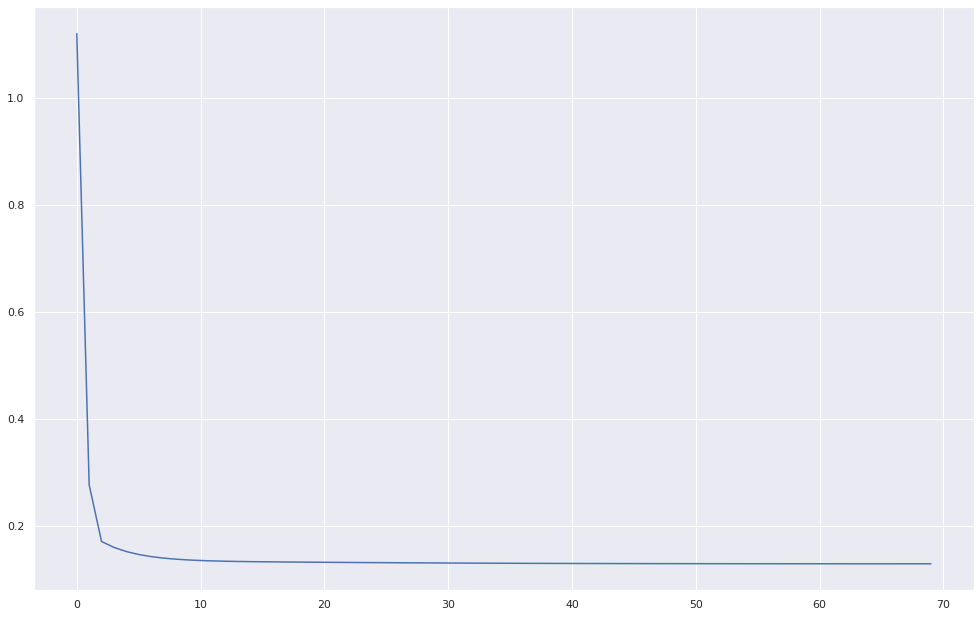

In [80]:
plt.plot(errs)
plt.show()

In [43]:
Q, q_hat

(array([[5, 3, 0, 1],
        [4, 0, 0, 1],
        [1, 1, 0, 5],
        [1, 0, 0, 4],
        [0, 1, 5, 4]]),
 array([[4.890259  , 2.87441981, 1.01813196, 1.01251902],
        [3.85836915, 2.28411455, 0.92804083, 0.99500925],
        [1.01021788, 0.97720797, 3.16144148, 4.84453882],
        [0.99073666, 0.88593608, 2.54298174, 3.87549708],
        [1.17212809, 0.99998297, 4.80000195, 3.9999967 ]]))

# The End